# **Machine Learning and Neural Networks End Term Assessment**

## **Introduction**

In recent years, the explosive growth of online movie reviews has created a vast trove of data that can provide valuable insights into the public's opinions and preferences on various films. Sentiment analysis, the task of automatically identifying the sentiment or emotion expressed in a piece of text, has emerged as a powerful tool for analyzing and understanding these reviews.

In this report, I present my approach to building a deep learning model using TensorFlow to predict the sentiment of IMDB movie reviews. The goal is to develop a model that can accurately classify a movie review as positive or negative based on the text content.

## **Defining the problem**

We aim to address a binary classification problem and to achieve this, we will use the IMDB dataset provided by the TensorFlow library. The dataset provides us with both the samples and labels that we need to build our model. The reason we chose this source is because the dataset contains an equal number of positive and negative reviews, making it an ideal resource for training an unbiased model that does not lean towards a specific label.

### **Initializing TensorFlow, Keras and other dependencies**

In [3]:
# Importing all required libraries
import tensorflow as tf 
from tensorflow import keras
from keras.datasets import imdb
from keras import models, layers, optimizers, regularizers 

import random
import math
import numpy as np
import itertools
from prettytable import PrettyTable

import matplotlib.pyplot as plt

# Printing TensorFlow and Keras versions
print(f"tensorflow version = {tf.__version__}")
print(f"keras version = {keras.__version__}")

tensorflow version = 2.9.0
keras version = 2.9.0


### **Analysing the dataset**

In [4]:
# Limit to the number of words in one sample 
num_words_in_sample = 10000

# Loading the dataset
((train_samples, train_labels), (test_samples, test_labels)) = imdb.load_data(num_words = num_words_in_sample)

# Printing some training data samples and their labels
print("Training sample [100] = ", train_samples[100])
print("Training label [100] = ", train_labels[100], "\n")
print("Training sample [200] = ", train_samples[200])
print("Training label [200] = ", train_labels[200], "\n")

# Printing all the available labels
print("All available labels = ", set(train_labels))

Training sample [100] =  [1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158]
Training label [100] =  0 

Training sample [200] =  [1, 14, 9, 6, 227, 196, 241, 634, 891, 234, 21, 12, 69, 6, 6, 176, 7, 4, 804, 4658, 2999, 667, 11, 12, 11, 85, 715, 6, 176, 7, 1565, 8, 1108, 10, 10, 12, 16, 1844, 2, 33, 211, 21, 69, 49, 2009, 905, 388, 99, 2, 125, 34, 6, 2, 1274, 33, 4

On inspecting the samples above we can see that each review sample consists of an array of integers. Each integer in the array of each sample is a word index and maps to a word. Using this mapping we can decode the array as shown below.  

In [3]:
word_dictionary = imdb.get_word_index()
reverse_word_dictionary = dict([(value, key) for (key, value) in word_dictionary.items ( )])
decoded_review = ' '.join([reverse_word_dictionary.get(i - 3, '?') for i in train_samples[100]])
print(f"Decoded training sample [100] = {decoded_review}")
print(f"Training label [100] = {train_labels[100]}")

Decoded training sample [100] = ? i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of ? drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was ? on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep ? the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the ? box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10
Training label [100] = 0


By decoding the message, we can deduce that a review labeled as `0` indicates a negative sentiment and a review labeled as `1` indicates a positive sentiment. Based on this information, we can make the following hypotheses to proceed with building our model:

* It is possible to predict the sentiment of a movie review using an array of word indices.
* The dataset we have contains enough information to learn the relationship between words in a review and their corresponding sentiment.

## **Defining a measure of success**

To proceed with building the model we have to first define a measure of success, the most common being `accuracy`, `precision`, `recall` and `loss`. Each of these measures has a different purpose. We will mainly use `accuracy` and `loss` to measure the success of our model. 

`accuracy` is the ratio of correctly classified samples out of the total number of samples in the dataset. It is a popular and intuitive metric for classification tasks, but it can be misleading in imbalanced datasets or when the costs of false positives and false negatives are different. Fortunately, however, we have a balanced dataset.

`loss` measures the error or cost of the model's predictions compared to the true labels. In binary classification, the cross-entropy loss is commonly used, which penalizes the model more for making incorrect predictions with high confidence and less for making correct predictions or uncertain predictions. The lower the `loss`, the better the model's predictions are.

Though `accuracy` is a good measure of success we will mainly focus on `loss`, since `loss` is a more generalised measure compared to `accuracy`, which is a performance metric specific to the validation or test set. We will use `accuracy` to weed out the bad models, but finally, we will use the model with the lowest `loss`.

### **Helper functions for measuring performance**

Below are some helper functions that we can use to analyze and measure performance throughout this project.

In [4]:
def get_prediction_accuracy(y_pred, y_true):
    """
    Calculate prediction accuracy and loss
    """
    matches = y_pred == y_true
    num_matches = len(matches[matches == True])
    accuracy = num_matches/len(matches)
    return accuracy


def draw_training_validation_plot(training_values, validation_values, metric_name):
    """
    Draw a plot comparing values of a metric in training and validation runs over epochs 
    """
    epochs = range(1, len(training_values) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, training_values, blue_dots, label = f"Training {metric_name.lower()}")
    plt.plot(epochs, validation_values, solid_blue_line, label = f"Validation {metric_name.lower()}")
    plt.title(f"Training and Validation {metric_name.lower().capitalize()}")
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.lower().capitalize())
    plt.legend()

    plt.show()

## **Deciding on an evaluation protocol**

Now that we have chosen the measure of success for our model, we need to determine the evaluation protocol to use during model development. The most common protocols are `Holdout Validation`, `K-Fold Validation`, and `Iterated K-Fold Validation`. Since we have a large, balanced dataset with 50,000 samples and 25,000 samples for each label, we will be using the `Holdout Validation` protocol.

The `Holdout Validation` protocol involves dividing the original training dataset into separate inner-training and validation datasets, typically with a split ratio of 80/20 or 70/30. We will test multiple hyperparameter combinations using this method and use the helper functions created earlier to identify the optimal combination. Our ultimate goal is to create a model with strong statistical power that avoids overfitting or underfitting.

Finally, we will build the final model using the entire training dataset and test it using the full testing dataset.

## **Preparing the data**

Data preparation is one of the most crucial steps when building the model and it will ulitimately decide if the model we build will be successful or not. When working with raw text data we always have to represent the data in terms of numerical values in order to use it with the deep learning model. This process is called vectorization. In our case, fortunately, the data samples we receive from TensorFlow are already vectorized using the `Bag of Word` approach. However as seen in the `Analysing the dataset` section each word is represented by different numbers and this can cause some problems:

* The model will assign greater importance to a word based on the numerical value used to represent it, which could result in some words being given more weight than others.
* The data samples have varying lengths, which prevents us from constructing tensors since tensors require fixed dimensions.

Both of these issues can be resolved by vectorizing the data using the `One Hot Encoding` approach, in which each word is converted to its own feature with a value of either `0` or `1`. This not only normalizes the numerical representation of words but also results in data samples of fixed lengths. The function below will vectorize the samples we have using the `One Hot Encoding` approach.

In [1]:
# This method is from the Machine Learning and Neural Network Lecture
def vectorize_samples(samples, dimension):
    """
    Vectorize samples from the IMDB dataset
    """
    results = np.zeros((len(samples), dimension))
    for i, sample in enumerate(samples):
        results[i, sample] = 1.
    return results

Data preparation also involves splitting the dataset into training and testing datasets. Fortunately this has been done already for as well by the `imdb.load_data` function which split our data into two balanced halves as seen below.

In [5]:
# Printing information about the loaded data
print(f"Training samples length = {len(train_samples)}")
print(f"Test samples length = {len(test_samples)}")

Training samples length = 25000
Test samples length = 25000


Finally, we will use the helper function we created above to prepare the data.

In [6]:
x_train = vectorize_samples(train_samples, num_words_in_sample)
x_test = vectorize_samples(test_samples, num_words_in_sample)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## **Developing a baseline model**

Having prepared the data, we can now proceed with building our model. However, before delving into complex model development, we need to establish a simple baseline model. A baseline model is a basic, unsophisticated model that serves as a benchmark for evaluating the performance of more advanced models. It provides a reference point for measuring the improvement of our new model over the baseline. For our purposes, we will implement a rudimentary and simplistic approach in our baseline model, randomly assigning labels to input data.

In [7]:
def baseline_model_predict(samples):
    """
    Baseline model prediction
    """
    return np.array([ float(round(random.random())) for i in range(len(samples)) ])
    
y_pred = baseline_model_predict(x_test)
print(f"Accuracy = {get_prediction_accuracy(y_pred, y_test)}")

Accuracy = 0.5054


Our baseline model has produced the expected results, achieving an accuracy rate of approximately 50%. This outcome is due to the dataset containing an equal number of samples for both labels. Our next objective is to construct a model that surpasses the statistical power of the baseline model and achieves a prediction accuracy greater than 50%.

## **Developing a model that does better than the baseline**

Now that we have established a clear baseline, our focus turns to creating a model that outperforms it. To establish a starting point, we will consider the following common guidelines when building our initial model:

* Build a small capacity model that is statistically powerful enough to beat the baseline model
* Use the default and industry standard hyperparameters like optimiser, loss and last-layer activation

In order to speed up development we will first create a function that trains and validates models with the provided hyperparameters.

In [8]:
def train_and_validate_model(x_train, y_train, sample_size, num_hidden_layers, num_hidden_layer_units, regularizer_alpha, optimizer_learning_rate, validation_split_ratio, epochs, batch_size):        
    """
    Builds a model using provided parameters then train and validates it and returns training history
    """
    # Build model
    model = models.Sequential()
    if regularizer_alpha == None: 
        model.add(layers.Dense(num_hidden_layer_units, activation = 'relu', input_shape = (sample_size,)))
    else:
        model.add(layers.Dense(num_hidden_layer_units, kernel_regularizer = regularizers.l1(regularizer_alpha), activation = 'relu', input_shape = (sample_size,)))
    for i in range(num_hidden_layers):
        model.add(layers.Dense(num_hidden_layer_units, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = optimizers.RMSprop(lr = optimizer_learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Train and validate model
    split_index = math.floor(len(x_train) * (1 - validation_split_ratio))
    x_val = x_train[:split_index]
    partial_x_train = x_train[split_index:]
    y_val = y_train[:split_index]
    partial_y_train = y_train[split_index:]

    training_history = model.fit(partial_x_train, partial_y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_val, y_val), verbose = 0)
    return training_history

Given that we are tackling a binary classification problem, we will employ the standard `sigmoid` activation function in the last layer and use `binary_crossentropy` as the loss function, which is commonly used in such problems. For the optimizer, we will select `rmsprop`, which has proven to be effective in various scenarios. In addition, we will maintain a compact network architecture, with a single hidden layer positioned between the input and output layers. This decision reflects our goal of delivering a minimum viable model that manages to outperform our baseline model.

In [9]:
# Building and training 1st model
model_training_history = train_and_validate_model(x_train = x_train,
                                                  y_train = y_train,
                                                  sample_size = num_words_in_sample,
                                                  num_hidden_layers = 1,
                                                  num_hidden_layer_units = 8,
                                                  regularizer_alpha = None,
                                                  optimizer_learning_rate = 0.001,
                                                  validation_split_ratio = 0.3, 
                                                  epochs = 20, 
                                                  batch_size = 256)
model_training_history_dict = model_training_history.history

print(f"Training Accuracy = {model_training_history_dict['accuracy'][-1]}")
print(f"Validation Accuracy = {model_training_history_dict['val_accuracy'][-1]}")

Metal device set to: Apple M1 Max


2023-03-10 13:03:44.475364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-10 13:03:44.476586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/harish/opt/anaconda3/envs/mlnn-end-term-assessment/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
2023-03-10 13:03:44.735630: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-10 13:03:44.956407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plug

Training Accuracy = 1.0
Validation Accuracy = 0.8592000007629395


We have confirmed our initial two hypotheses by successfully creating a model that outperforms the baseline model by a significant margin.

## **Scaling up and developing a model that overfits**

Now that we have our sufficiently powerful model, our next task will be to try making it more powerful. A good way to go about that is to scale up the model until it overfits. 

But before proceeding with scaling up the model we will also analyse the change in validation loss and validation accuracy over the epochs, to find out if our initial model overfits. 

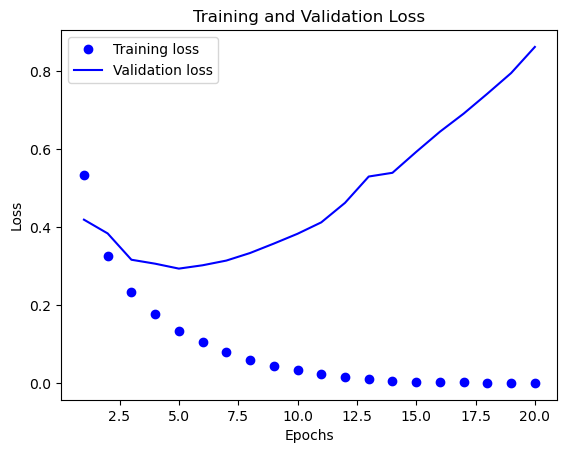

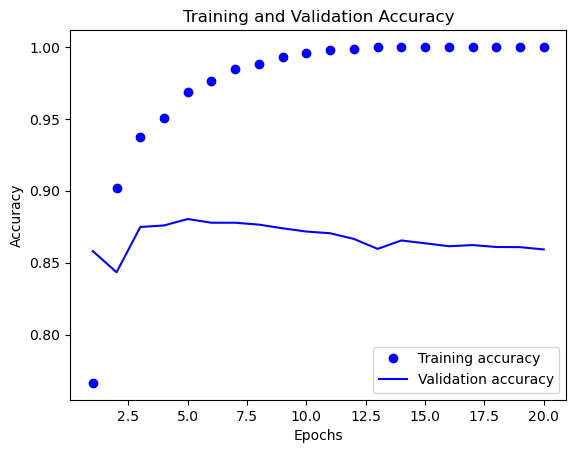

In [10]:
# Plotting validation and training loss and accuracy 
draw_training_validation_plot(model_training_history_dict['loss'], model_training_history_dict['val_loss'], 'Loss')
draw_training_validation_plot(model_training_history_dict['accuracy'], model_training_history_dict['val_accuracy'], 'Accuracy')

The plots clearly show that the model does not perform as well on the validation dataset as it does on the training dataset. Unlike the training dataset, where the loss and accuracy improve with every epoch, the validation loss and accuracy reach their respective optimal values at epoch `5`. This is a clear indication that our model is already overfitting. Nonetheless, we will continue to explore other possibilities and scale up the model to ensure that it is sufficiently statistically powerful to handle the problem at hand.

There are many ways to scale up a model. We will achieve this by making the existing layers bigger.

In [11]:
# Building and training the scaled up model
model_training_history = train_and_validate_model(x_train = x_train,
                                                  y_train = y_train,
                                                  sample_size = num_words_in_sample,
                                                  num_hidden_layers = 1,
                                                  num_hidden_layer_units = 128,
                                                  regularizer_alpha = None,
                                                  optimizer_learning_rate = 0.001,
                                                  validation_split_ratio = 0.3, 
                                                  epochs = 20, 
                                                  batch_size = 256)
model_training_history_dict = model_training_history.history

print(f"Training Accuracy = {model_training_history_dict['accuracy'][-1]}")
print(f"Validation Accuracy = {model_training_history_dict['val_accuracy'][-1]}")

2023-03-10 16:24:45.839257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 16:24:46.866861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training Accuracy = 1.0
Validation Accuracy = 0.8675428628921509


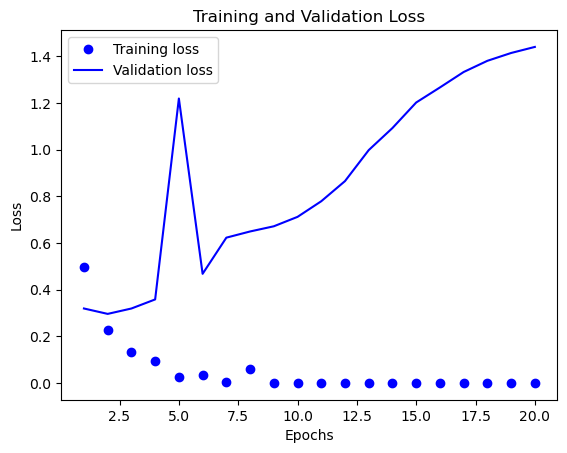

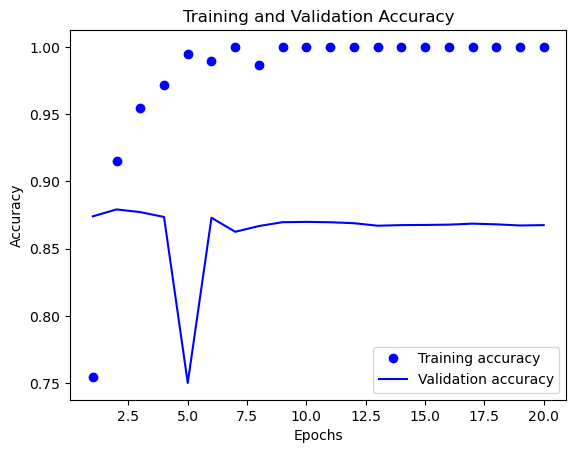

In [12]:
# Plotting validation and training loss and accuracy 
draw_training_validation_plot(model_training_history_dict['loss'], model_training_history_dict['val_loss'], 'Loss')
draw_training_validation_plot(model_training_history_dict['accuracy'], model_training_history_dict['val_accuracy'], 'Accuracy')

As anticipated, we observe that this model is prone to overfitting heavily on the training dataset, leading to worsened performance beyond epoch `3`. This is demonstrated by the validation loss, which increases substantially after epoch `3`. Thus, we have successfully developed a model with a significant degree of statistical power that overfits.

## **Regularising the model and tuning the hyperparameters**

Although our initial small-scale model has achieved a similar accuracy and lower loss than the larger overfitting model, we will still attempt to fine-tune the latter to explore the possibility of improving its statistical power without overfitting.

Overfitting is a prevalent issue in machine learning, and several techniques can be employed to mitigate it. In our case, we will experiment with three methods and different combinations thereof to tackle this problem.

* **Using L1 (Lasso) regularisation**: L1 regularization is a technique to combat overfitting by reducing the magnitude of the parameters towards zero, thereby eliminating some of the features. This method is particularly suitable for the type of review samples we are training on, which contain a significant number of stop words such as "the", "or" and "if", that we can ignore completely, especially since we are not considering the order of words when training the model.
* **Reducing size of layers**: By doing so, the model becomes less likely to memorize the training data and instead focuses on capturing more general patterns that can be applied to new data. Thus, decreasing the size of layers is a good technique to help the model generalize better and avoid overfitting.
* **Adjusting the learning rate of the optimizer**: Learning rate controls how much the weights of the model are updated with each batch of training data. If the learning rate is too high, the model may overshoot the optimal weights and fail to converge. On the other hand, if the learning rate is too low, the model may take a long time to converge or get stuck in a suboptimal local minimum. By adjusting the learning rate, we can help the optimizer find the global minimum of the loss function more efficiently, resulting in better performance of the deep learning model.

We will try different combinations of all these techniques and choose the best combination for our final model.

In [13]:
# Deciding on differnt values to test for the discussed properties and techniques
l1_regularization_alpha_values = np.arange(0.001, 0.01, 0.003)
layer_size_values = np.array([8, 16, 32, 64, 128])
learning_rate_values = np.arange(0.001, 0.01, 0.003)

hyper_parameter_combinations = list(itertools.product(l1_regularization_alpha_values, layer_size_values, learning_rate_values))

results = []

for hyper_parameter_combination in hyper_parameter_combinations:
    regularizer_alpha = hyper_parameter_combination[0]
    num_hidden_layer_units = hyper_parameter_combination[1]
    optimizer_learning_rate = hyper_parameter_combination[2]
    
    model_training_history = train_and_validate_model(x_train = x_train,
                                                  y_train = y_train,
                                                  sample_size = num_words_in_sample,
                                                  num_hidden_layers = 1,
                                                  num_hidden_layer_units = num_hidden_layer_units,
                                                  regularizer_alpha = regularizer_alpha,
                                                  optimizer_learning_rate = optimizer_learning_rate,
                                                  validation_split_ratio = 0.3, 
                                                  epochs = 20, 
                                                  batch_size = 256)
    model_training_history_dict = model_training_history.history
    results.append({
        "training_parameters": hyper_parameter_combination,
        "training_history": model_training_history_dict
    })
    
print(f"Attempted {len(results)} different combinations!")

2023-03-10 17:19:49.469250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 17:19:50.380301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 17:20:03.377434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 17:20:04.325607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 17:20:17.391501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 17:20:18.492848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 17:20:31.423800: I tensorflow/core/grappler/optimizers/cust

Attempted 80 different combinations!


In [15]:
# Printing a tabulated version of the results
table = PrettyTable(['index',
                     'reg_alpha', 
                     'layer_size', 
                     'lrng_rate', 
                     'val_accu', 
                     'val_loss', 
                     'best_val_accu', 
                     'best_val_loss',
                     'ideal_epochs'])
for index, result in enumerate(results):
    val_accuracy = result['training_history']['val_accuracy']
    val_loss = result['training_history']['val_loss']

    # Extracting data for the table row
    regularizer_alpha = result['training_parameters'][0]
    layer_size = result['training_parameters'][1]
    optimizer_learning_rate = result['training_parameters'][2]
    final_validation_accuracy = round(val_accuracy[-1], 3)
    final_validation_loss = round(val_loss[-1], 3)
    best_validation_accuracy = round(max(val_accuracy), 3)
    best_validation_loss = round(min(val_loss), 3)
    ideal_num_epochs = (val_loss.index(min(val_loss)) + 1) # Ideal number of epochs will be chosen based on epoch with lowest loss
    
    table.add_row([index,
                  regularizer_alpha,
                  layer_size,
                  optimizer_learning_rate,
                  final_validation_accuracy,
                  final_validation_loss,
                  best_validation_accuracy,
                  best_validation_loss,
                  ideal_num_epochs])
    
print(table)

+-------+-----------+------------+-----------+----------+----------+---------------+---------------+--------------+
| index | reg_alpha | layer_size | lrng_rate | val_accu | val_loss | best_val_accu | best_val_loss | ideal_epochs |
+-------+-----------+------------+-----------+----------+----------+---------------+---------------+--------------+
|   0   |   0.001   |     8      |   0.001   |  0.862   |  0.481   |      0.87     |     0.459     |      16      |
|   1   |   0.001   |     8      |   0.004   |  0.849   |  0.675   |     0.868     |     0.591     |      3       |
|   2   |   0.001   |     8      |   0.007   |   0.84   |  0.853   |     0.865     |     0.731     |      7       |
|   3   |   0.001   |     8      |    0.01   |  0.816   |  0.966   |     0.863     |     0.848     |      6       |
|   4   |   0.001   |     16     |   0.001   |  0.857   |  0.532   |      0.87     |     0.508     |      17      |
|   5   |   0.001   |     16     |   0.004   |  0.859   |  0.834   |    

We have tried `80` different combinations of hyperparameters tuning. From looking at the above table we can see a lot of combinations yielding high accuracies but they are all very close. We will choose the best combination based on loss since it is more important than accuracy as mentioned in the `Defining the measure of success` section. 

It is clear that the first combination has the lowest loss. We'll analyse it's results in the plot below to see if there is any overfitting or underfitting.

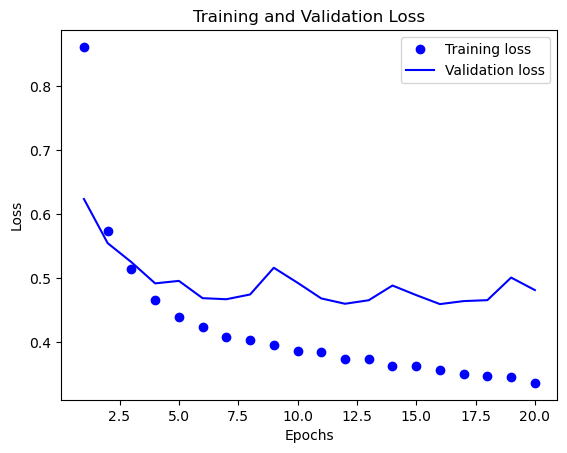

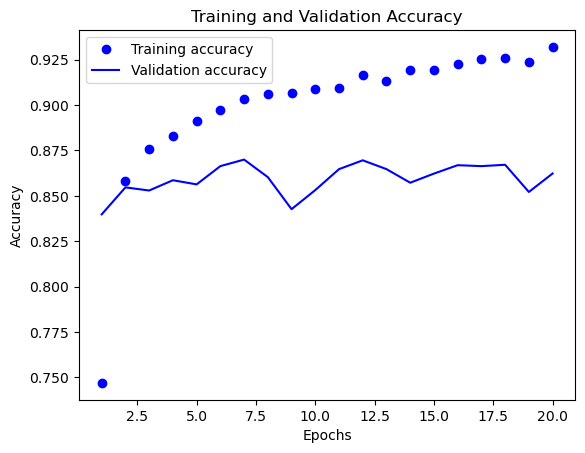

In [16]:
# Unpacking the results of the 1st combination
result = results[0]
accuracy = result['training_history']['accuracy']
val_accuracy = result['training_history']['val_accuracy']
loss = result['training_history']['loss']
val_loss = result['training_history']['val_loss']

# Plotting validation and training loss and accuracy 
draw_training_validation_plot(loss, val_loss, 'Loss')
draw_training_validation_plot(accuracy, val_accuracy, 'Accuracy')

The validation accuracy and loss are now closely resembling the training accuracy and loss respectively. The plots show that they are considerably more stable than the previous models, indicating a reduction in overfitting or underfitting. From the table and plot, we can determine that epoch `16` produces the best loss. Therefore, we will use `16` as the number of epochs for our final model.


## **Building and evaluating the final model**

We have determined the optimal combination of hyperparameters and training parameters, and are now ready to build our final model.

Here is the configuration we will be using for the model:

| regularizer_alpha | layer_size | learning_rate | val_accuracy | val_loss | best_val_accuracy | best_val_loss | ideal_epochs | batch_size |
|:-----------------:|:----------:|:-------------:|:------------:|:--------:|:-----------------:|:-------------:|:------------:|:----------:|
| 0.001             | 8          | 0.001         | 0.862        | 0.481    | 0.87              | 0.459         | 16           | 256        |

In [20]:
final_model = models.Sequential()
final_model.add(layers.Dense(8, kernel_regularizer = regularizers.l1(0.001), activation = 'relu', input_shape = (num_words_in_sample,)))
final_model.add(layers.Dense(8, activation = 'relu'))
final_model.add(layers.Dense(1, activation = 'sigmoid'))
final_model.compile(optimizer = optimizers.RMSprop(lr = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
final_model.fit(x_train, y_train, epochs = 16, batch_size = 256, verbose = 0)

results = final_model.evaluate(x_test, y_test, verbose = 0)
print(f"Loss - {results[0]}")
print(f"Accuracy - {results[1]}")

2023-03-10 19:19:56.222605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-10 19:20:11.680117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Loss - 0.4158256947994232
Accuracy - 0.8812400698661804


Our final model's performance is close and even slighlty better than results we had during validation, proving our validation protocol for fine tuning the hyperparameters was good. Provided below is the prediction results of the first few samples in the test dataset.

In [34]:
table = PrettyTable(['index',
                     'predicted_label', 
                     'actual_label'])

y_pred = final_model.predict(x_test[0:20], verbose = 0)

for i in range(0, 20):
    table.add_row([i, round(y_pred[i][0]), round(y_test[i])])
    
print(table)
print(f"The model predicted {get_prediction_accuracy([round(pred[0]) for pred in y_pred], y_test[0:20]) * 100}% of the first 20 samples")

+-------+-----------------+--------------+
| index | predicted_label | actual_label |
+-------+-----------------+--------------+
|   0   |        0        |      0       |
|   1   |        1        |      1       |
|   2   |        1        |      1       |
|   3   |        1        |      0       |
|   4   |        1        |      1       |
|   5   |        1        |      1       |
|   6   |        1        |      1       |
|   7   |        0        |      0       |
|   8   |        1        |      0       |
|   9   |        1        |      1       |
|   10  |        1        |      1       |
|   11  |        0        |      0       |
|   12  |        0        |      0       |
|   13  |        0        |      0       |
|   14  |        1        |      1       |
|   15  |        0        |      0       |
|   16  |        1        |      1       |
|   17  |        1        |      0       |
|   18  |        0        |      0       |
|   19  |        0        |      0       |
+-------+--

## **Conclusion**

In this project, we developed a deep neural network model to analyze the sentiment of IMDB movie reviews. We used a dataset of reviews, preprocessed the data, and trained a deep neural network to classify reviews as either positive or negative.

Our final model achieved an accuracy of `88%` and a loss of `0.481` on the test set, which exceeds our baseline model very easily, especially considering that our baseline model was randomly choosing labels and lacked statistical power, suggesting that our approach was successful. 

The final model uses the following network configuration:

|   | Type  | Number of Units | Activation Function | Input Shape | Kernel Regularizer             |
|:-:|:-----:|:---------------:|:-------------------:|:-----------:|:------------------------------:|
| 1 | Dense | 8               | relu                | 10000, 8    | L1 Regularizer (alpha = 0.001) |
| 2 | Dense | 8               | relu                | 8, 8        | nil                            |
| 3 | Dense | 1               | sigmoid             | 8, 1        | nil                            |

* **Optimiser:** RMSProp(learning_rate = 0.001)
* **Loss:** binary_crossentropy
* **Epochs:** 16
* **Batch Size:** 256


Through experimentation, we found the best combination of learning rate, L1 regularizer alpha and number of units mentioned above.

Our model was successful in accurately classifying the sentiment of IMDB movie reviews. This model has practical applications in areas such as market research about movies. Future work could involve exploring the use of different architectures, evaluating the model on other datasets, and exploring other natural language processing techniques.


## **References**

1. Chollet, F. (2017) “Fundamentals of machine learning,” in Deep learning with python. Manning Publications, pp. 111–116. 
2. University of London, CM3015 Machine Learning at Neural Network Module 